In [1]:
import spacy
from keras.applications.vgg16 import VGG16
from keras.applications.inception_resnet_v2 import InceptionResNetV2
import matplotlib.pyplot as plt
from keras.utils import plot_model,multi_gpu_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import Model
from keras.models import load_model
from keras.layers import Input,GlobalAveragePooling2D,Layer,InputSpec
from keras.layers.core import Dense,Flatten,Dropout
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import np_utils
import keras.backend as K
import keras.layers as kl
from keras.preprocessing import sequence
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from time import time
import pickle
from keras.models import model_from_json
# from AttentionModule import SelfAttention, SoftAttention
import os
os.environ["CUDA_VISIBLE_DEVICES"]='2'
import cv2
from tqdm.notebook import tqdm
import AttentionMed as AM
from importlib import reload
reload(AM)
from time import time,localtime,strftime
from ipywidgets import IntProgress
# from coord import CoordinateChannel2D

Using TensorFlow backend.


In [2]:
# /media/MyDataStor1/mshaikh2/project_xray/notebooks

In [3]:
n_gpu=3
n_cpu=1
tf_config= tf.ConfigProto(device_count = {'GPU': n_gpu , 'CPU': n_cpu})
tf_config.gpu_options.allow_growth=True
s=tf.Session(config=tf_config)
K.set_session(s)

In [4]:
nlp = spacy.load('en_core_web_md')

In [5]:
path=os.getcwd() #Get the path
path

'/media/MyDataStor1/mshaikh2/project_xray/notebooks'

In [6]:
proj_ds=pd.read_csv(path+'/../dataset/indiana_projections.csv')
repo_ds=pd.read_csv(path+'/../dataset/indiana_reports.csv')

display(proj_ds.head(50),proj_ds.shape)
display(repo_ds.sort_values(by='uid').head(),repo_ds.shape)

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal
5,3,3_IM-1384-2001.dcm.png,Lateral
6,4,4_IM-2050-1001.dcm.png,Frontal
7,4,4_IM-2050-2001.dcm.png,Lateral
8,5,5_IM-2117-1003002.dcm.png,Frontal
9,5,5_IM-2117-1004003.dcm.png,Lateral


(7466, 3)

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.


(3851, 8)

In [7]:
f_proj_ds = proj_ds[proj_ds.projection=='Frontal']
f_proj_ds = f_proj_ds.sort_values(by='uid')
display(f_proj_ds.head())
f_proj_ds.shape

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
2,2,2_IM-0652-1001.dcm.png,Frontal
4,3,3_IM-1384-1001.dcm.png,Frontal
6,4,4_IM-2050-1001.dcm.png,Frontal
8,5,5_IM-2117-1003002.dcm.png,Frontal


(3818, 3)

In [8]:
c_repo_ds = repo_ds.dropna(subset=['findings','impression'],how='any')
display(c_repo_ds.head())
c_repo_ds.shape

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.
5,6,normal,normal,"PA and Lateral Chest. XXXX, XXXX at XXXX",Evaluate for infection,"XXXX, XXXX",Heart size and mediastinal contour are within ...,No acute cardiopulmonary findings.


(3331, 8)

In [9]:
merged_ds = pd.merge(left=c_repo_ds,right=proj_ds,on='uid',how='inner')

merged_ds = merged_ds[merged_ds.projection=='Frontal']
display(merged_ds.head())
merged_ds.shape

,uid,MeSH,Problems,image,indication,comparison,findings,impression,filename,projection
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,1_IM-0001-4001.dcm.png,Frontal
2,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,2_IM-0652-1001.dcm.png,Frontal
4,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...,4_IM-2050-1001.dcm.png,Frontal
6,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.,5_IM-2117-1003002.dcm.png,Frontal
8,6,normal,normal,"PA and Lateral Chest. XXXX, XXXX at XXXX",Evaluate for infection,"XXXX, XXXX",Heart size and mediastinal contour are within ...,No acute cardiopulmonary findings.,6_IM-2192-1001.dcm.png,Frontal


(3301, 10)

In [10]:
# chars = []
# char_count = {}
# finding_len = []
# max_len=0
# for finding in c_repo_ds.findings:
#     tokens = finding.lower()
#     for i in list("[-<>:.,()]/"):
#         tokens = tokens.replace(i,' ')
#     tokens=tokens.strip()
#     if max_len<len(tokens):
#         max_len=len(tokens)
#     finding_len.append(len(tokens))
#     chars+=tokens
# for impr in c_repo_ds.impression:
#     tokens = impr.lower()
#     for i in list("[-<>:.,()]/"):
#         tokens = tokens.replace(i,' ')
#     tokens=tokens.strip()
#     chars+=tokens
#     if max_len<len(tokens):
#         max_len=len(tokens)
#     finding_len.append(len(tokens))
# print(len(list(set(chars))))
# for char in chars:
#     if char not in char_count.keys():
#         char_count[char]=1
#     else:
#         char_count[char]+=1
# df_ccount = pd.DataFrame()
# df_ccount['chars']=char_count.keys()
# df_ccount['c_count']=char_count.values()
# df_ccount = df_ccount.sort_values(by='c_count',ascending=False).reset_index()
# display(df_ccount.head(10))
# df_ccount['index'].max(),max_len

In [11]:
# sent_len_arr=[]
# wo_len_arr = []
# for row in tqdm_notebook(merged_ds['findings'].values):
#     doc = nlp(row)
#     sentences = [sent.string.strip() for sent in doc.sents]
#     sent_len_arr.append(len(sentences))
#     sentence = ' '.join(sentences[:7])
#     sdoc = nlp(sentence)
#     ls_sdoc = [str(x) for x in list(sdoc)]
#     wo_len_arr.append(len(ls_sdoc))

In [12]:
# df_sent_len = pd.DataFrame(sent_len_arr,columns=['count'])
# df_word_len = pd.DataFrame(wo_len_arr,columns=['count'])
# df_sent_len.shape,df_word_len.shape

In [13]:
# df_word_len.describe()

In [14]:
# df_sent_len[df_sent_len['count']>7].shape,df_word_len[df_word_len['count']>60].shape


In [16]:
# ch_to_co = df_ccount
# ch_to_co.index = ch_to_co.chars
# ch_to_co = ch_to_co['index'].to_dict()
# display(ch_to_co)
# co_to_ch = df_ccount
# co_to_ch.index = co_to_ch['index']
# co_to_ch = co_to_ch['chars'].to_dict()
# display(co_to_ch)
nlp_obj = nlp(merged_ds['findings'][0])


In [31]:
for s in nlp_obj.sents:
    print(s.vector[:10])
    print(len(s))
    w_vec = np.zeros(300,)
    for w in s:
        w_vec += w.vector
    w_vec /= len(s)
    print(w_vec[:10])
    break
# tokens = nlp('startseq ' 
#              + ' '.join(c_repo_ds.impression.values).lower().replace('/',' ')
#              + ' endseq.' 
#              + ' startseq' 
#              + ' '.join(c_repo_ds.findings.values).lower().replace('/',' ')
#              + ' endseq.')

[-0.02794309  0.16324891 -0.33056453 -0.0426463  -0.06106273 -0.16613925
  0.09451318  0.06222766  0.13323453  1.8223783 ]
11
[-0.02794309  0.16324891 -0.33056454 -0.0426463  -0.06106273 -0.16613924
  0.09451317  0.06222767  0.13323454  1.8223782 ]


In [17]:
# vocab = [str(x) for x in tokens]
# vocab

In [18]:
# word_count = {}
# for word in vocab:
#     if word not in word_count.keys():
#         word_count[word]=1
#     else:
#         word_count[word]+=1
# df_wcount = pd.DataFrame()
# df_wcount['words']=word_count.keys()
# df_wcount['w_count']=word_count.values()
# df_wcount = df_wcount.sort_values(by='w_count',ascending=False).reset_index()
# df_wcount['index']+=1

# df_wcount.to_csv('../dataset/vocab_count.csv',index=False)
df_wcount = pd.read_csv('../dataset/vocab_count.csv')

display(df_wcount)
vocab_size=df_wcount.shape[0]
max_wlen = 60
print(vocab_size,max_wlen)

,index,words,w_count
0,1608,.,21069
1,1667,no,6824
2,1855,the,6596
3,1370,is,4367
4,538,are,4312
5,910,normal,3548
6,99,",",3534
7,1380,xxxx,3080
8,1089,of,3043
9,1675,and,3029


1942 60


In [19]:
new_words= [word for word in df_wcount['words'].values if not word.isalnum()]
print(len(new_words),new_words)

74 ['.', ',', '-', '..', "'s", ':', '(', ')', ' ', ';', '1.4', '>', '3.3', '1.9', '<', 'bilaterally.there', '1.2', '1.0', '2.1', 'p.m.', '1.7', '1.5', '3.5', '1.6', '3.7', '[', 't12-l1', '1.8', "xxxx't", '?', '2.0', '4.5', '2.2', '3.2', "'re", 'l1-l2', '4.6', 'xxxx.in', 'a.m.', 'l2-l3', '4.3', 'contour.unfolded', 'effusion.heart', '0.9', '5.9', '5.8', 'apex.there', '16.2', 'body(lateral', 'xxxx-', '2.no', '2.6', '1.severe', ']', '1.there', 'enlargement.prominence', '1.lucency', '6.0', '2.8', '1.3', '1.1', '3.chronic', 'limits.the', '2.5', 'limits.minimal', '4.8', 'normal.calcified', 'mediastinum.there', '7.0', '24.7', '3rd-5xxxx', '6.8', '3.0', '  ']


In [20]:
w_to_co = df_wcount
w_to_co.index = w_to_co.words
w_to_co = w_to_co['index'].to_dict()
# print(w_to_co)
co_to_w = df_wcount
co_to_w.index = co_to_w['index']
co_to_w = co_to_w['words'].to_dict()
# print(co_to_w)

In [21]:
# df = pd.DataFrame(sorted(finding_len,reverse=True))
# display(df.head(50))
# df.plot(kind='hist',figsize=(6,6))
co_to_w[13]

'mediport'

In [22]:
embedding_size = 300
# embedding_matrix = np.zeros((vocab_size+1, embedding_size)) # last one : to cater to empty/-1
# for word,idx in w_to_co.items():
#     token = nlp(word)
#     embedding_matrix[idx] = token.vector
# embedding_matrix[vocab_size] = np.zeros(embedding_size)
embedding_matrix = pd.read_pickle('../dataset/initial_emb_mat.p')
embedding_matrix = embedding_matrix.values
# print(embedding_matrix.shape)
# df_emb = pd.DataFrame(embedding_matrix)
# df_emb.to_pickle('../dataset/initial_emb_mat.p')

# Parameters

In [23]:
img_arch = 'vgg'
text_arch = '1dcnn'
model_name = '{0}_{1}_text_img_attention'.format(img_arch,text_arch)
EPOCHS = 50
lr = 0.0001
img_dropout_rate=0.5
text_dropout_rate=0.8
elu_alpha = 1.0

# Model Initialization

In [24]:
def VGGNet():
    image_input = Input(shape=(256,256,3),name='image_input')
    # x = CoordinateChannel2D()(inp)
    x = kl.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', name='block1_conv1')(image_input)
    x = kl.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', name='block1_conv2')(x)
    x = kl.Conv2D(filters=64, kernel_size=2, strides=2, activation='relu', padding='same', name='block1_reduction_conv')(x)
    x = kl.BatchNormalization()(x)
    x = kl.Dropout(img_dropout_rate)(x)

    x = kl.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', name='block2_conv1')(x)
    x = kl.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', name='block2_conv2')(x)
    x = kl.Conv2D(filters=128, kernel_size=2, strides=2, activation='relu', padding='same', name='block2_reduction_conv')(x)
    x = kl.BatchNormalization()(x)
    x = kl.Dropout(img_dropout_rate)(x)

    x = kl.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', name='block3_conv1')(x)
    x = kl.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', name='block3_conv2')(x)
    x = kl.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', name='block3_conv3')(x)
    x = kl.Conv2D(filters=256, kernel_size=2, strides=2, activation='relu', padding='same', name='block3_reduction_conv')(x)
    x = kl.BatchNormalization()(x)
    x = kl.Dropout(img_dropout_rate)(x)

    x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block4_conv1')(x)
    x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block4_conv2')(x)
    x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block4_conv3')(x)
    # x = CoordinateChannel2D(use_radius=True)(x)
#     x, samap, g = SelfAttention(ch=512, name='self_attention')(x)
    x = kl.Conv2D(filters=512, kernel_size=2, strides=2, activation='relu', padding='same', name='block4_reduction_conv')(x)
    x = kl.BatchNormalization()(x)
    x = kl.Dropout(img_dropout_rate)(x)

    x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block5_conv1')(x)
    x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block5_conv2')(x)
    x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block5_conv3')(x)
#     x, amaps = SoftAttention(ch=512, m=32, name='soft_attention')(x)
    x = kl.Conv2D(filters=512, kernel_size=2, strides=2, activation='relu', padding='same', name='block5_reduction_conv')(x)
    return Model(image_input,x,name='imgModel')
# def DenseNet():
#     qw = Input(shape=(256,256,3),name='image_input')
#     qw_1 = kl.Conv2D(strides=1,padding='valid',activation='relu',filters=64,name='conv',kernel_size=3)(qw)

#     qw_1 = densenet.densenet.conv_block(x=qw_1,growth_rate=64,name='conv_1',)

#     qw_2 = densenet.densenet.dense_block(qw_1,blocks=1,name='block_1')
#     qw_2 = kl.BatchNormalization()(qw_2)
#     qw_2 = kl.Activation('relu')(qw_2)
#     qw_2 = kl.Conv2D(filters=64, kernel_size=2, strides=2, activation='relu', padding='same', name='block1_reduction_conv')(qw_2)
#     qw_2 = kl.Dropout(0.5)(qw_2)

#     qw_2 = densenet.densenet.dense_block(qw_2,blocks=1,name='block_2')
#     qw_2 = kl.BatchNormalization()(qw_2)
#     qw_2 = kl.Activation('relu')(qw_2)
#     # qw_2 = kl.MaxPool2D(pool_size=2)(qw_2)
#     qw_2 = kl.Conv2D(filters=128, kernel_size=2, strides=2, activation='relu', padding='same', name='block2_reduction_conv')(qw_2)
#     qw_2 = kl.Dropout(0.5)(qw_2)

#     qw_2 = densenet.densenet.dense_block(qw_2,blocks=1,name='block_3')
#     qw_2 = kl.BatchNormalization()(qw_2)
#     qw_2 = kl.Activation('relu')(qw_2)
#     # qw_2 = kl.MaxPool2D(pool_size=2)(qw_2)
#     qw_2 = kl.Conv2D(filters=256, kernel_size=2, strides=2, activation='relu', padding='same', name='block3_reduction_conv')(qw_2)
#     qw_2 = kl.Dropout(0.5)(qw_2)

#     qw_2 = densenet.densenet.dense_block(qw_2,blocks=1,name='block_4')
#     qw_2 = kl.BatchNormalization()(qw_2)
#     qw_2 = kl.Activation('relu')(qw_2)
#     # qw_2 = kl.MaxPool2D(pool_size=2)(qw_2)
#     qw_2 = kl.Conv2D(filters=512, kernel_size=2, strides=2, activation='relu', padding='same', name='block4_reduction_conv')(qw_2)
#     qw_2 = kl.Dropout(0.5)(qw_2)

#     qw_2 = densenet.densenet.dense_block(qw_2,blocks=1,name='block_5')
#     qw_2 = kl.BatchNormalization()(qw_2)
#     qw_2 = kl.Activation('relu')(qw_2)
#     # qw_2 = kl.MaxPool2D(pool_size=2)(qw_2)
#     qw_2 = kl.Conv2D(filters=1024, kernel_size=2, strides=2, activation='relu', padding='same', name='block5_reduction_conv')(qw_2)
#     # qw_2 = kl.Dropout(0.5)(qw_2)
#     qw_2 = kl.BatchNormalization()(qw_2)
#     qw_2 = kl.Activation('relu')(qw_2)

#     return Model(qw,qw_2, name='imgModel')

In [25]:
if img_arch=='vgg':
    imgNet = VGGNet()
elif img_arch == 'densenet121':
    imgNet = DenseNet121(include_top=False,input_shape=(256,256,3))
    imgNet.trainable = True
elif img_arch == 'densenet':
    imgNet = DenseNet()
elif img_arch == 'irv2':
    imgNet =InceptionResNetV2(include_top=False,input_shape=(256,256,3))
    imgNet.trainable = True
if os.path.exists('../checkpoints/{0}_{1}_attention_img_module.h5'.format(img_arch,text_arch)):
    print('loading existing image weights..')
    imgNet.load_weights('../checkpoints/{0}_{1}_attention_img_module.h5'.format(img_arch,text_arch))
imgNet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_reduction_conv (Conv2 (None, 128, 128, 64)      16448     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
__________

In [26]:
bottleneck_units = 512
def getTextNet():
    words_input = kl.Input(shape=(max_wlen,),name='words_input')
    padding_masks = kl.Input(shape=(max_wlen,1),name='padding_masks')
    x2 = kl.Embedding(vocab_size+1, embedding_size, mask_zero=False, name='w2v_emb')(words_input)
    xk3 = kl.Conv1D(filters=324,kernel_size=3,strides=1,padding='same')(x2)
    xk3 = kl.ELU(alpha=elu_alpha)(xk3)
    xk5 = kl.Conv1D(filters=324,kernel_size=5,strides=1,padding='same')(x2)
    xk5 = kl.ELU(alpha=elu_alpha)(xk5)
    xk7 = kl.Conv1D(filters=324,kernel_size=7,strides=1,padding='same')(x2)
    xk7 = kl.ELU(alpha=elu_alpha)(xk7)
    xk3d2 = kl.Conv1D(filters=324,kernel_size=3,strides=1,dilation_rate=2, padding='same')(x2)
    xk3d2 = kl.ELU(alpha=elu_alpha)(xk3d2)
    xk5d2 = kl.Conv1D(filters=324,kernel_size=5,strides=1,dilation_rate=2, padding='same')(x2)
    xk5d2 = kl.ELU(alpha=elu_alpha)(xk5d2)
    xk7d2 = kl.Conv1D(filters=324,kernel_size=7,strides=1,dilation_rate=2, padding='same')(x2)
    xk7d2 = kl.ELU(alpha=elu_alpha)(xk7d2)
    x2 = kl.Concatenate()([xk3,xk5,xk7,xk3d2,xk5d2,xk7d2])
#     x2 = kl.BatchNormalization()(x2)
#     x2 = kl.ELU(alpha=elu_alpha)(x2)
    x2 = kl.Conv1D(filters=bottleneck_units,kernel_size=1,strides=1,padding='same')(x2)
    x2 = kl.BatchNormalization()(x2)
    x2 = kl.ELU(alpha=elu_alpha)(x2)
    # print('x2.shape:',x2.shape)
    x2 = kl.Dropout(text_dropout_rate)(x2)
    sa_out_x2_1,s_x2_1 = AM.SelfAttention(ch=int(x2.shape[-1]),name='sa_2_1')([x2,padding_masks])
    sa_out_x2_2,s_x2_2 = AM.SelfAttention(ch=int(x2.shape[-1]),name='sa_2_2')([x2,padding_masks])
    sa_out_x2_3,s_x2_3 = AM.SelfAttention(ch=int(x2.shape[-1]),name='sa_2_3')([x2,padding_masks])
    sa_out_x2_4,s_x2_4 = AM.SelfAttention(ch=int(x2.shape[-1]),name='sa_2_4')([x2,padding_masks])
#     print(sa_out_x2_4)
    x3 = kl.Concatenate(name='concat_sa_2')([sa_out_x2_1,sa_out_x2_2,sa_out_x2_3,sa_out_x2_4])
    # x3 = kl.ELU(alpha=elu_alpha,name='act_concat_sa_2')(x3)
    x3comb,x3_g1,x3_g2 = AM.ResidualCombine1D(ch_in=int(x3.shape[-1]),ch_out=bottleneck_units)([x2,x3])
    x3comb = kl.BatchNormalization()(x3comb)
    # x3comb = kl.ELU(alpha=elu_alpha)(x3comb)
    x3comb = kl.Conv1D(filters=bottleneck_units,kernel_size=1,strides=1,padding='same')(x3comb)
    x3comb = kl.BatchNormalization()(x3comb)
    x3comb = kl.ELU(alpha=elu_alpha)(x3comb)
    x3comb = kl.Dropout(text_dropout_rate)(x3comb)
    
    sa_out_x3_1,s_x3_1 = AM.SelfAttention(ch=int(x3comb.shape[-1]),name='sa_3_1')([x3comb,padding_masks])
    sa_out_x3_2,s_x3_2 = AM.SelfAttention(ch=int(x3comb.shape[-1]),name='sa_3_2')([x3comb,padding_masks])
    sa_out_x3_3,s_x3_3 = AM.SelfAttention(ch=int(x3comb.shape[-1]),name='sa_3_3')([x3comb,padding_masks])
    sa_out_x3_4,s_x3_4 = AM.SelfAttention(ch=int(x3comb.shape[-1]),name='sa_3_4')([x3comb,padding_masks])
    x4 = kl.Concatenate(name='concat_sa_3')([sa_out_x3_1,sa_out_x3_2,sa_out_x3_3,sa_out_x3_4])
    # x4 = kl.ELU(alpha=elu_alpha,name='act_concat_sa_3')(x4)
    x4comb,x4_g1,x4_g2 = AM.ResidualCombine1D(ch_in=int(x4.shape[-1]),ch_out=bottleneck_units)([x3comb,x4])
    x4comb = kl.BatchNormalization()(x4comb)
    # x4comb = kl.ELU(alpha=elu_alpha)(x4comb)
    x4comb = kl.Conv1D(filters=bottleneck_units,kernel_size=1,strides=1,padding='same')(x4comb)
    x4comb = kl.BatchNormalization()(x4comb)
    x4comb = kl.ELU(alpha=elu_alpha)(x4comb)
    # x4comb = kl.Dropout(dropout_rate)(x4comb)
    
    # sa_out_x4_1,s_x4_1 = SelfAttention(ch=int(x4comb.shape[-1]),name='sa_4_1')([x4comb,padding_masks])
    # sa_out_x4_2,s_x4_2 = SelfAttention(ch=int(x4comb.shape[-1]),name='sa_4_2')([x4comb,padding_masks])
    # sa_out_x4_3,s_x4_3 = SelfAttention(ch=int(x4comb.shape[-1]),name='sa_4_3')([x4comb,padding_masks])
    # sa_out_x4_4,s_x4_4 = SelfAttention(ch=int(x4comb.shape[-1]),name='sa_4_4')([x4comb,padding_masks])
    # x5 = kl.Concatenate(name='concat_sa_4')([sa_out_x4_1,sa_out_x4_2,sa_out_x4_3,sa_out_x4_4])
    # x5 = kl.ELU(alpha=elu_alpha,name='act_concat_sa_4')(x5)
    # x5comb,x5_g1,x5_g2 = ResidualCombine1D(ch_in=int(x5.shape[-1]),ch_out=bottleneck_units)([x4comb,x5]) 
    # x5comb = kl.BatchNormalization()(x5comb)
    # x5comb = kl.ELU(alpha=elu_alpha)(x5comb)
    # x5comb = kl.Conv1D(filters=bottleneck_units,kernel_size=1,strides=1,padding='same')(x5comb)
    # x5comb = kl.BatchNormalization()(x5comb)
    # x5comb = kl.ELU(alpha=elu_alpha)(x5comb)
    
    return Model([words_input,padding_masks],x4comb,name='textModel')

In [29]:
textNet = None

In [30]:
textNet = getTextNet()
textNet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words_input (InputLayer)        (None, 60)           0                                            
__________________________________________________________________________________________________
w2v_emb (Embedding)             (None, 60, 300)      582900      words_input[0][0]                
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 60, 324)      291924      w2v_emb[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 60, 324)      486324      w2v_emb[0][0]                    
__________________________________________________________________________________________________
conv1d_12 

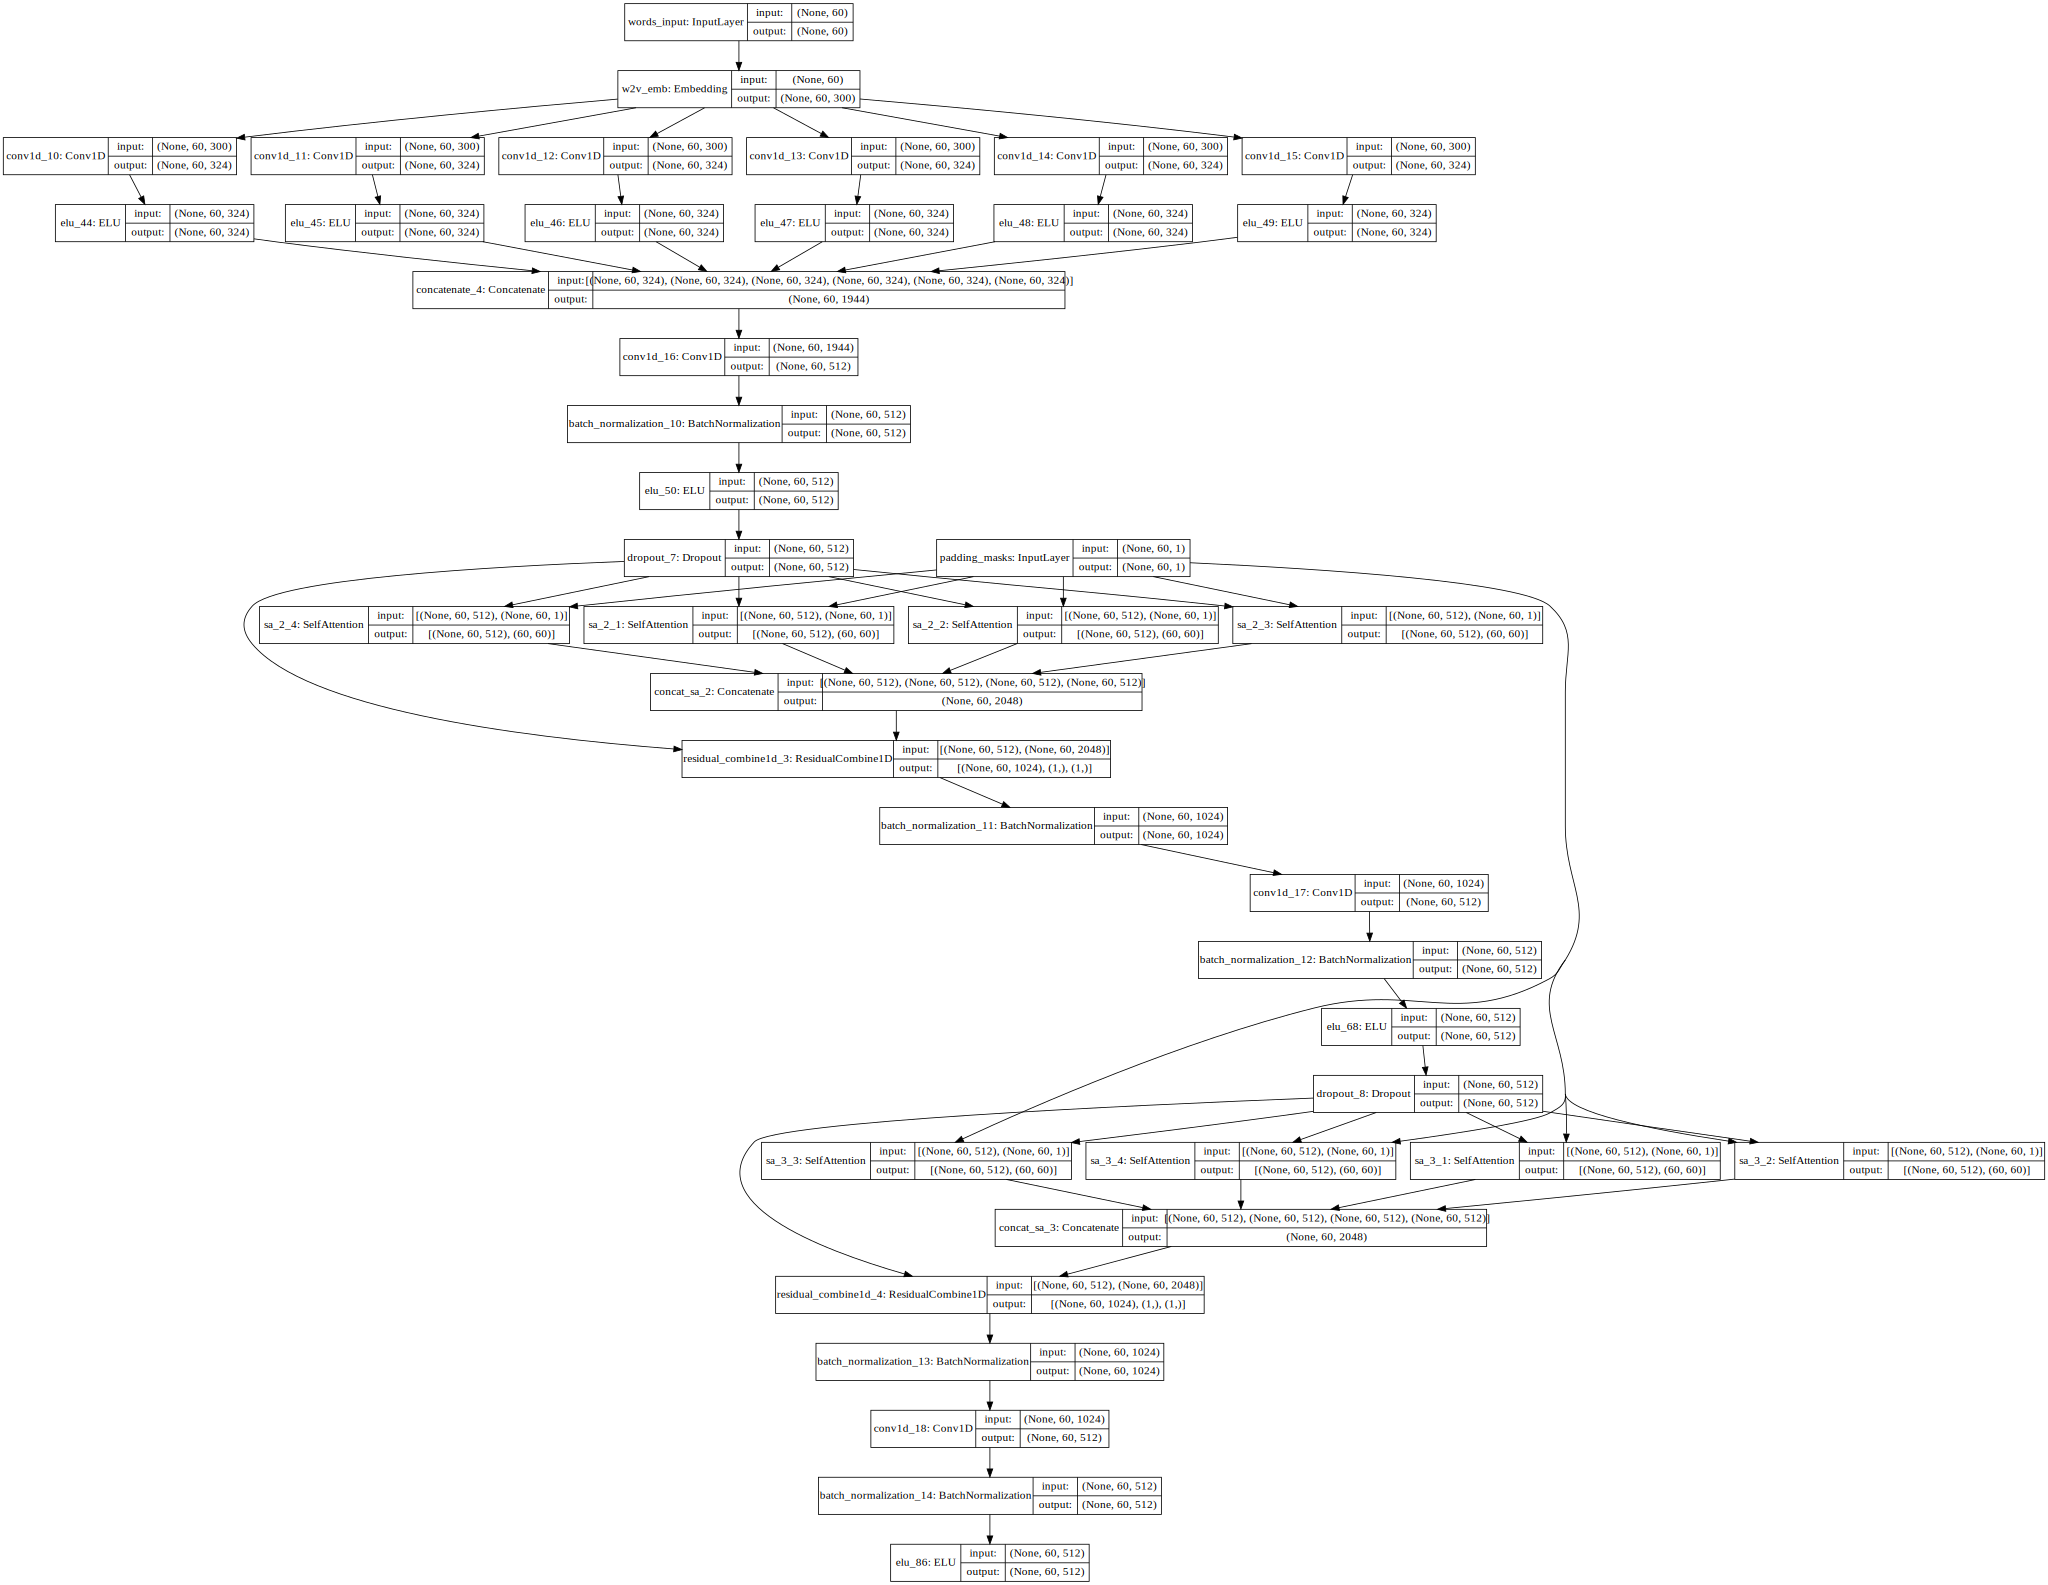

In [31]:
SVG(model_to_dot(textNet, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

# Define Complete Joint Network

In [33]:
dropout_rate = 0.8
image_input = kl.Input(shape=(256,256,3),name='image_input')
image_features = imgNet(image_input)
image_features = kl.Dropout(dropout_rate)(image_features)

padding_masks = kl.Input(shape=(max_wlen,1),name='padding_masks')
words_input = kl.Input(shape=(max_wlen,),name='words_input')

text_features = textNet([words_input,padding_masks])
text_features = kl.Dropout(dropout_rate)(text_features)
print(image_features.shape)
print(text_features.shape)

(?, 8, 8, 512)
(?, 60, 512)


In [34]:
a_out_im_1,beta_im_1 = AM.Img2TextCA(text_ch=int(text_features.shape[-1]),img_ch=int(image_features.shape[-1]),name='img2text_1')([image_features,text_features,padding_masks])
a_out_im_1 = kl.BatchNormalization()(a_out_im_1)
# a_out_im_1 = kl.ELU(alpha=elu_alpha)(a_out_im_1)
a_out_im_2,beta_im_2 = AM.Img2TextCA(text_ch=int(text_features.shape[-1]),img_ch=int(image_features.shape[-1]),name='img2text_2')([image_features,text_features,padding_masks])
a_out_im_2 = kl.BatchNormalization()(a_out_im_2)
# a_out_im_2 = kl.ELU(alpha=elu_alpha)(a_out_im_2)
a_out_im_3,beta_im_3 = AM.Img2TextCA(text_ch=int(text_features.shape[-1]),img_ch=int(image_features.shape[-1]),name='img2text_3')([image_features,text_features,padding_masks])
a_out_im_3 = kl.BatchNormalization()(a_out_im_3)
# a_out_im_3 = kl.ELU(alpha=elu_alpha)(a_out_im_3)
a_out_im_4,beta_im_4 = AM.Img2TextCA(text_ch=int(text_features.shape[-1]),img_ch=int(image_features.shape[-1]),name='img2text_4')([image_features,text_features,padding_masks])
a_out_im_4 = kl.BatchNormalization()(a_out_im_4)
# a_out_im_4 = kl.ELU(alpha=elu_alpha)(a_out_im_4)
a_conc_im_out = kl.Concatenate(name='img2text_concat')([a_out_im_1,a_out_im_2,a_out_im_3,a_out_im_4])
# a_conc_im_out = kl.BatchNormalization()(a_conc_im_out)
# print('a_conc_im_out.shape:',a_conc_im_out.shape)

img2text_comb,g1,g2 = AM.ResidualCombine2D(ch_in=int(a_conc_im_out.shape[-1]),ch_out=512)([image_features,a_conc_im_out])
img2text_comb = kl.BatchNormalization(name='img2text_comb_batchnorm')(img2text_comb)
img2text_comb = kl.ELU(alpha=elu_alpha)(img2text_comb)
img2text_comb = kl.Dropout(0.5)(img2text_comb)
img2text_pool = kl.GlobalAveragePooling2D(name='img2text_global_pool')(img2text_comb)


In [35]:
a_out_1,beta_1 = AM.Text2ImgCA(text_ch=int(text_features.shape[-1]),img_ch=int(image_features.shape[-1]),name='text2img_1')([text_features,image_features,padding_masks])
a_out_1 = kl.BatchNormalization()(a_out_1)
# a_out_1 = kl.ELU(alpha=elu_alpha)(a_out_1)
# print(a_out_1.shape)
a_out_2,beta_2 = AM.Text2ImgCA(text_ch=int(text_features.shape[-1]),img_ch=int(image_features.shape[-1]),name='text2img_2')([text_features,image_features,padding_masks])
a_out_2 = kl.BatchNormalization()(a_out_2)
# a_out_2 = kl.ELU(alpha=elu_alpha)(a_out_2)
# print(a_out_2.shape)
a_out_3,beta_3 = AM.Text2ImgCA(text_ch=int(text_features.shape[-1]),img_ch=int(image_features.shape[-1]),name='text2img_3')([text_features,image_features,padding_masks])
a_out_3 = kl.BatchNormalization()(a_out_3)
# a_out_3 = kl.ELU(alpha=elu_alpha)(a_out_3)
# print(a_out_3.shape)
a_out_4,beta_4 = AM.Text2ImgCA(text_ch=int(text_features.shape[-1]),img_ch=int(image_features.shape[-1]),name='text2img_4')([text_features,image_features,padding_masks])
a_out_4 = kl.BatchNormalization()(a_out_4)
# a_out_4 = kl.ELU(alpha=elu_alpha)(a_out_4)
# print(a_out_4.shape)
a_conc_out = kl.Concatenate(name='text2img_concat')([a_out_1,a_out_2,a_out_3,a_out_4])
a_conc_out = kl.BatchNormalization()(a_conc_out)
# print('a_conc_out.shape:',a_conc_out.shape)

text2img_comb,g1,g2 = AM.ResidualCombine1D(ch_in=int(a_conc_out.shape[-1]),mode='add',ch_out=512)([text_features,a_conc_out])
text2img_comb = kl.BatchNormalization(name='text2img_comb_batchnorm')(text2img_comb)
text2img_comb = kl.ELU(alpha=elu_alpha)(text2img_comb)
text2img_comb = kl.Dropout(dropout_rate)(text2img_comb)
text2img_pool = kl.GlobalAveragePooling1D(name='text2img_global_pool')(text2img_comb)


In [36]:
all_concat = kl.Concatenate()([img2text_pool,text2img_pool])
cross_pool = kl.Dense(512)(all_concat)
cross_pool = kl.ELU(alpha=elu_alpha)(cross_pool)
cross_pool = kl.Dropout(dropout_rate)(cross_pool)
target = kl.Dense(vocab_size+1, activation='softmax',name='target_word')(cross_pool)
model = Model([image_input,words_input,padding_masks],target)


In [37]:
# json_file = open('../model_json/{0}_{1}_text_img_attention.json'.format(img_arch,text_arch), 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)

In [38]:
# loaded_model_json

In [39]:
# loaded_model==model

In [40]:

if not os.path.exists('../checkpoints/{0}.h5'.format(model_name)):
    print('New model {0}. loading word2vec embeddings'.format(model_name))
    l = textNet.get_layer('w2v_emb')
    l.set_weights([embedding_matrix])
    l.trainable = False
else:
    print('Existing model {0}. trained weights will be loaded'.format(model_name))
    model.load_weights('../checkpoints/{0}.h5'.format(model_name))

New model vgg_1dcnn_text_img_attention. loading word2vec embeddings


In [41]:
# w_to_co
# textNet.load_weights('../checkpoints/irv2_1dcnn_attention_text_module.h5')
# imgNet.load_weights('../checkpoints/irv2_1dcnn_attention_img_module.h5')

In [42]:

model.summary()
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr),metrics=['accuracy'])
# model.load_weights('../checkpoints/{0}.h5'.format(model_name))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
words_input (InputLayer)        (None, 60)           0                                            
__________________________________________________________________________________________________
padding_masks (InputLayer)      (None, 60, 1)        0                                            
__________________________________________________________________________________________________
imgModel (Model)                (None, 8, 8, 512)    17161216    image_input[0][0]                
__________________________________________________________________________________________________
textModel 

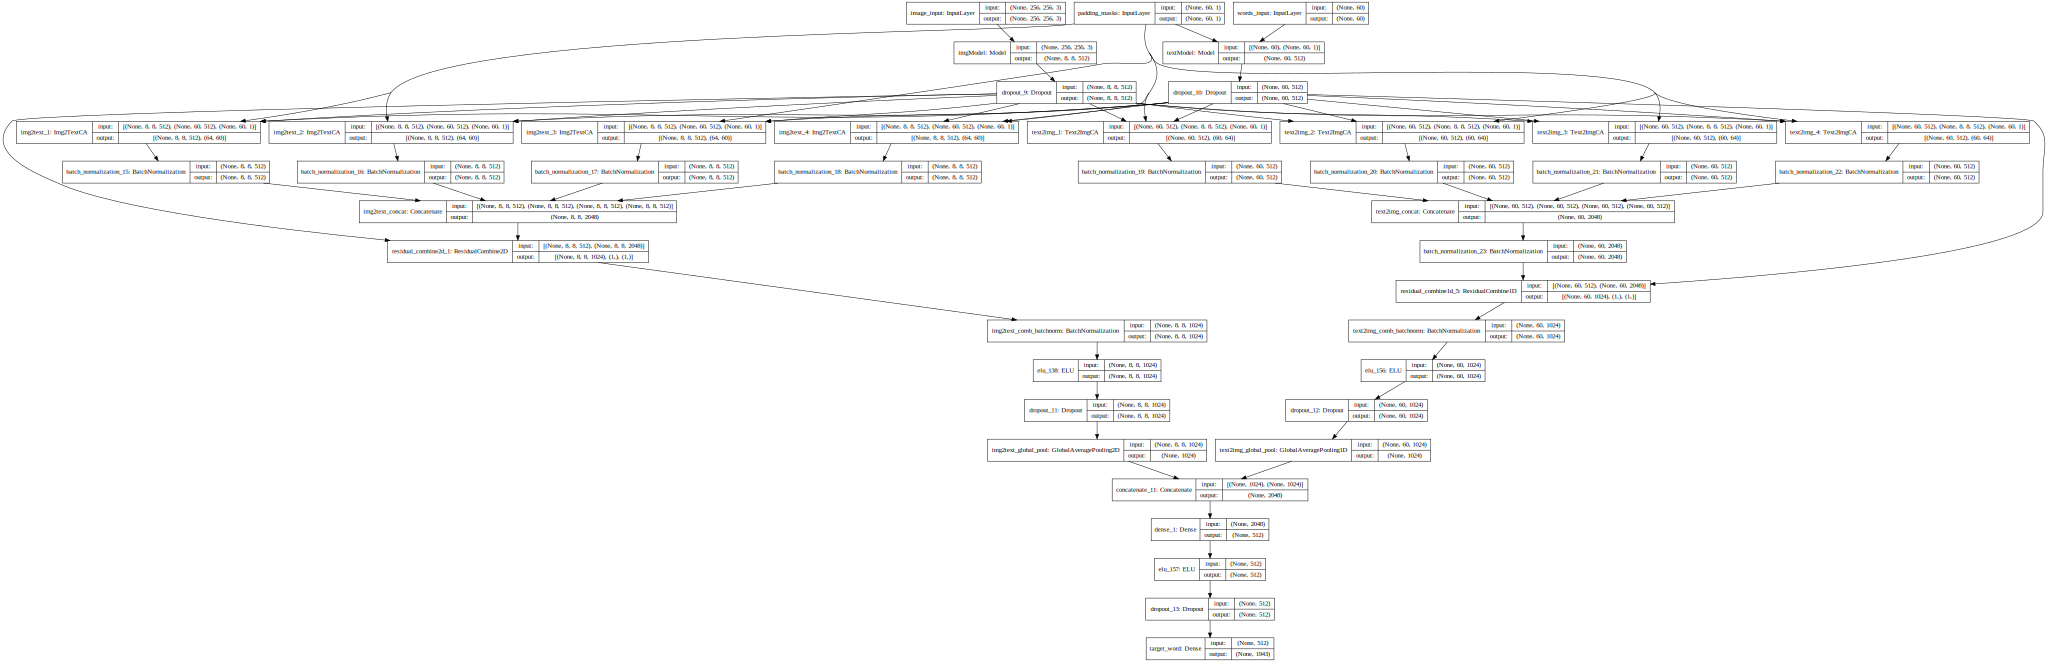

In [43]:
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))


In [44]:
model_json = model.to_json()
with open("../model_json/{0}.json".format(model_name), "w") as json_file:
    json_file.write(model_json)


In [45]:
model_name

'vgg_1dcnn_text_img_attention'

In [46]:
# emb = Model(textNet.inputs[0],textNet.get_layer('w2v_emb').output)
# emb.summary()


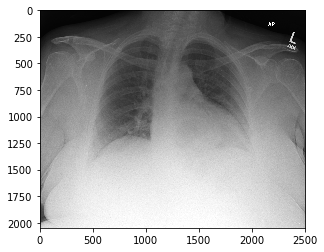

In [47]:
img = cv2.imread('../dataset/images/images_normalized/3591_IM-1770-1001-0001.dcm.png')
plt.imshow(img)

In [48]:
def datagen(img_lst,batch_size=4):
    counter=0
    x1,x2,y,sents,masks, img_names = [],[],[],[],[],[]
    idx = 0
    while True:
        im = img_lst[idx]
        
        photo = cv2.imread('../dataset/images/images_normalized/resized_1024/{0}'.format(im))/255.0
        sent = merged_ds[merged_ds.filename==im]['findings'].values[0].lower().replace('/',' ')
        
        ts = nlp(sent)
#         print(ts)
        ts = [str(x) for x in list(ts)]
#         print(tss)
        ts = ts[:max_wlen-1]
        sent_words = ['startseq']
        for t in ts:
#             print(t)
#             t = 'sdadasasdasads'
            if (t not in w_to_co.keys()) : #or ('xx' in t):
#                 print('not present:',t)
                pass
            else:
                sent_words.append(t)
        sent_words.append('endseq')
#         print(sent_words)

        seq = [w_to_co[x] for x in sent_words]
        # split one sequence into multiple X, y pairs
        for i in range(1, len(seq)):
            
            in_seq, out_seq = seq[:i], seq[i]
#             print(out_seq)
            in_seq = sequence.pad_sequences([in_seq], maxlen=max_wlen,padding='pre',value=0)[0]
            mask = [0.001 if x<1 else  1 for x in in_seq]
            mask = np.expand_dims(mask,-1)
            out_seq = np_utils.to_categorical([out_seq], num_classes=vocab_size+1)[0]
            x1.append(photo)
            img_names.append(im)
            x2.append(in_seq)
            masks.append(mask)
            y.append(out_seq)
            sents.append(sent)
        counter+=1
        idx+=1
#         print(idx)
        if idx==len(img_lst):
            idx=0
        if counter==batch_size:
            counter=0
            inputs = {'image_input': np.array(x1),
                      'words_input': np.array(x2),
                      'padding_masks':np.array(masks),
                      'image_names':np.array(img_names)
                     }
            outputs = {'target_word':np.array(y),
                      'actual_sentence':np.array(sents)}
            yield inputs, outputs
            x1,x2,y,sents,masks,img_names = [],[],[],[],[],[]

In [49]:


with open('../dataset/train_images.p', 'rb') as filehandle:
    # read the data as binary data stream
    train_images_list = pickle.load(filehandle)
with open('../dataset/val_images.p', 'rb') as filehandle:
    # read the data as binary data stream
    val_images_list = pickle.load(filehandle)
with open('../dataset/test_images.p', 'rb') as filehandle:
    # read the data as binary data stream
    test_images_list = pickle.load(filehandle)

print('train:',len(train_images_list),
      '+ val:',len(val_images_list),
      '+ test:',len(test_images_list),
      ' = ',(len(train_images_list)+len(val_images_list)+len(test_images_list)))
train_batch_size = 64
val_batch_size = 64
test_batch_size = 1
train_gen = datagen(train_images_list,batch_size=train_batch_size)
val_gen = datagen(val_images_list,batch_size=val_batch_size)
test_gen = datagen(test_images_list,batch_size=test_batch_size)

train: 2209 + val: 631 + test: 316  =  3156


In [50]:
# test_images_list = merged_ds.filename.values
# test_images_list = list(test_images_list)
# for x in train_images_list:
#     test_images_list.remove(x)
# for x in val_images_list:
#     test_images_list.remove(x)
# len(test_images_list)

In [51]:
# imgs = merged_ds.filename.values
# np.random.shuffle(imgs)

# train_images_list = imgs[:int(0.7*len(imgs))]
# val_images_list = imgs[int(0.7*len(imgs)):int(0.9*len(imgs))]
# test_images_list = imgs[int(0.9*len(imgs)):]
# train_images_list.shape,val_images_list.shape,test_images_list.shape
# with open('../dataset/train_images.p', 'wb') as file:
#     # store the data as binary data stream
#     pickle.dump(train_images_list, file)
# with open('../dataset/val_images.p', 'wb') as file:
#     # store the data as binary data stream
#     pickle.dump(val_images_list, file)
# with open('../dataset/test_images.p', 'wb') as file:
#     # store the data as binary data stream
#     pickle.dump(test_images_list, file)
# # tx,ty = next(train_gen)
# # tx['padding_masks'][30].shape

In [52]:

# display(tx['image_input'].shape
#         ,tx['words_input'][30]
#         ,tx['padding_masks'][30]
#         ,' '.join([co_to_w[x] if x !=0 else '' for x in tx['words_input'][30]])
#         ,ty['actual_sentence'][30])


In [53]:
len(val_images_list),len(train_images_list), w_to_co['xxxx']

(631, 2209, 1380)

In [54]:
# # def _ctc_lambda_func(args):
# #     labels, y_pred, input_length, label_length = args
# #     return K.tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)
# vggnet.summary()
# w_to_co['xxxx']
# np.clip(0,a_max=1,a_min=1e-8)

In [55]:
# print(co_to_w[273])
# print(embedding_matrix[1380])
# for u,v in zip(tx['words_input'][0],tx['padding_masks'][0]):
#     print(u,v)

In [56]:
# att = np.random.randint(1,10,(4,5,5))
# mask = 1-np.triu(np.ones((4,5,5)),k=1)
# att*mask
vx,vy = next(val_gen)

In [57]:
for i in range(200):
    print('---',i,'---')
    print('['+vx['image_names'][i]+'], input_seq:',', '.join(['<None> {0}'.format(y) if x==0 else '<{0}> {1}'.format(co_to_w[x],y) for x,y in zip(vx['words_input'][i],vx['padding_masks'][i])]),', \t next_word:',co_to_w[np.argmax(vy['target_word'][i])])

--- 0 ---
[3212_IM-1517-2001.dcm.png], input_seq: <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <start

In [58]:
print(vx['words_input'][1])
embedding_matrix[105]

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0  105 1450]


array([0.87749377, 0.70275573, 0.2821012 , 0.81863486, 0.74583549,
       0.34336174, 0.6239491 , 0.78875861, 0.88404274, 0.47183051,
       0.39509649, 0.52243708, 0.07633962, 0.81263937, 0.39995035,
       0.54251465, 0.33023597, 0.38177721, 0.72792975, 0.28376835,
       0.1962039 , 0.24933322, 0.25449001, 0.37835411, 0.17022616,
       0.7451347 , 0.12770332, 0.40862071, 0.15203045, 0.4578276 ,
       0.71059968, 0.2139542 , 0.45761894, 0.61981414, 0.9277183 ,
       0.19679774, 0.88094972, 0.04810931, 0.02994228, 0.32311452,
       0.69152694, 0.61853972, 0.31041178, 0.14744789, 0.67535795,
       0.43940283, 0.65170832, 0.82738837, 0.82410592, 0.14035516,
       0.72441303, 0.55140711, 0.61970473, 0.41845017, 0.79335535,
       0.43796208, 0.99479203, 0.18528307, 0.77601376, 0.90879176,
       0.4355555 , 0.96815896, 0.81644619, 0.28018123, 0.04958191,
       0.54413741, 0.9244749 , 0.47654332, 0.14145499, 0.25458149,
       0.68814974, 0.7652857 , 0.25055083, 0.67300159, 0.35400

In [59]:
# emb_out = emb.predict(tx['words_input'])
# emb_out[1][-2]

In [60]:
parallel_model=multi_gpu_model(model, gpus=3)
# # model_resnet.summary()
# # parallel_model.load_weights('./../checkpoints/sa_vgg16_3d_32x24_m32_direct.h5', by_name=True, skip_mismatch=True)

In [61]:
parallel_model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=lr),metrics=['accuracy']) #For multi GPU
parallel_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
words_input (InputLayer)        (None, 60)           0                                            
__________________________________________________________________________________________________
padding_masks (InputLayer)      (None, 60, 1)        0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           image_input[0][0]                
__________________________________________________________________________________________________
lambda_2 (

In [62]:
# mc=ModelCheckpoint(filepath='../checkpoints/vgg16_lstm_words.h5',monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto',verbose=3)
# es=EarlyStopping(patience=300,monitor='val_loss',min_delta=0.0001,mode='auto')

print('training {0} for {1} epochs'.format(model_name,EPOCHS))
# lr = K.eval(parallel_model.optimizer.lr)
# decay = 1e-3

training vgg_1dcnn_text_img_attention for 50 epochs


In [63]:
def CheckSelfAttention(input_data,labels):
    words_input,padding_masks=input_data
    for i in range(words_input.shape[0]):
        print('-*-*-',i,'-*-*-')
        print('input_seq:',', '.join(['<None> {0}'.format(y) if x==0 else '<{0}> {1}'.format(co_to_w[x],y) for x,y in zip(words_input[i],padding_masks[i])]),', \t next_word:',co_to_w[np.argmax(labels[i])])
    model_concat_sa_2 = Model(textNet.inputs,textNet.get_layer('concat_sa_2').output)
    model_concat_sa_3 = Model(textNet.inputs,textNet.get_layer('concat_sa_3').output)
    model_concat_sa_4 = []#Model(textNet.inputs,textNet.get_layer('act_concat_sa_4').output)
    
    return [model_concat_sa_2.predict(input_data)
            , model_concat_sa_3.predict(input_data)
            , []#model_concat_sa_4.predict(input_data)
            , textNet.predict(input_data)]
#     print(concat_sa_2)
    
def ReduceLROnPlateau(decay=0.5):
    old_lr = K.eval(parallel_model.optimizer.lr)
    new_lr = old_lr * decay
    return old_lr,new_lr

In [64]:
# ReduceLROnPlateau()

In [65]:
patience = 2
patience_counter = 0
min_delta = 0.001

In [ ]:
from IPython.display import clear_output

# counter = 0

# history = model.fit_generator(train_gen
#                               ,epochs=EPOCHS
#                               ,steps_per_epoch=4
#                               ,validation_data=val_gen
#                               ,validation_steps=2
#                               ,callbacks=[mc])

hist_tl,hist_ta,hist_vl,hist_va,tt,lr_arr = [],[],[],[],[],[]
window = 128
val_window = 128
train_iterations = int(np.ceil(len(train_images_list)/train_batch_size))
val_iterations = int(np.ceil(len(val_images_list)/val_batch_size))

print('train_iterations:{0}; val_iterations:{1}'.format(train_iterations,val_iterations))
min_v_l = 100
t_l, t_a, v_l, v_a = 0, 0, 4.01, 0
train_gen = datagen(train_images_list,batch_size=train_batch_size)
val_gen = datagen(val_images_list,batch_size=val_batch_size)
for e in tqdm(np.arange(start=0,stop=EPOCHS),desc='Epoch'):
    start_time = time()
    tl,ta,vl,va = [],[],[],[]
    for im in tqdm(range(train_iterations),desc='Train_Iter',leave=False):
        train_gen = datagen(train_images_list,batch_size=train_batch_size)
        tx,ty = next(train_gen)
        inputs1 = tx['image_input']
        inputs2 = tx['words_input']
        inputs3 = tx['padding_masks']
#         print(inputs3.shape)
        labels = ty['target_word']        
        for i in np.arange(len(inputs1),step=window):
            
            loss,accuracy = parallel_model.train_on_batch([inputs1[i:i+window],inputs2[i:i+window],inputs3[i:i+window]],labels[i:i+window])
#             concat_sa_2,concat_sa_3,concat_sa_4,textNet_output = CheckSelfAttention([inputs2[i:i+window],inputs3[i:i+window]],labels[i:i+window])            
            
            tl.append(loss)
            ta.append(accuracy)
            print('Train Iter:{0:3d}/{1}, tr_loss:{2:.4f}, tr_acc:{3:.4f} (min_v_loss:{4:.4f})'
                  .format(i+1,len(inputs1)
                          , np.mean(tl)
                          , np.mean(ta)
                          , min_v_l), end = '\r')
#             break
#         break
#     break
    for im in tqdm(range(val_iterations),desc='Val_Iter',leave=False):
        vx,vy = next(val_gen)
        inputs1 = vx['image_input']
        inputs2 = vx['words_input']
        inputs3 = vx['padding_masks']
        labels = vy['target_word']
        for i in np.arange(len(inputs1),step=val_window):
            loss,accuracy = parallel_model.evaluate(verbose=0,x=[inputs1[i:i+val_window],inputs2[i:i+val_window],inputs3[i:i+val_window]],y=labels[i:i+val_window])
            vl.append(loss)
            va.append(accuracy)
    v_l = np.round(np.mean(vl),4)
    v_a = np.round(np.mean(va),4)
    t_l = np.round(np.mean(tl),4)
    t_a = np.round(np.mean(ta),4)
    
    hist_tl.append(t_l)
    hist_ta.append(t_a)
    hist_vl.append(v_l)
    hist_va.append(v_a)
    if len(hist_tl)>=3:
        if hist_tl[-2]-hist_tl[-1]<min_delta:
            patience_counter+=1
            if patience==patience_counter:
                old_lr,lr = ReduceLROnPlateau()
                patience_counter = 0
                K.set_value(parallel_model.optimizer.lr,lr)
                K.set_value(model.optimizer.lr,lr)
    lr_arr.append(lr)
    if v_l < min_v_l:
        min_v_l = v_l
        model.save_weights(filepath='../checkpoints/{0}.h5'.format(model_name),overwrite=True)
        imgNet.save_weights(filepath='../checkpoints/{0}_{1}_img_module.h5'.format(img_arch,text_arch),overwrite=True)
        textNet.save_weights(filepath='../checkpoints/{0}_{1}_text_module.h5'.format(img_arch,text_arch),overwrite=True)
    clear_output(wait=True)
    end_time = time()
    time_taken = end_time-start_time
    tt.append(time_taken)
    with open('../tf_runs/log.csv','a') as f:
        data = '{0:3d}/{7},{1:.4f},{2:.4f},{3:.4f},{4:.4f},{6:.4f},{8:.6f}'.format(e+1, t_l, t_a, v_l, v_a, np.mean(tt),min_v_l,EPOCHS,lr)
        t = strftime("%m/%d/%Y %H:%M:%S",localtime())
        f.writelines('\n[{0}],{1},{2}'.format(t, model_name,data))
    print('E:{0:3d}/{7}, tr_loss:{1:.4f}, tr_acc:{2:.4f}, v_loss:{3:.4f}, v_acc:{4:.4f}, lr:{8:.6f} [{5:.2f} s/e] (min_v_loss:{6:.4f})'.format(e+1, t_l, t_a, v_l, v_a, np.mean(tt),min_v_l,EPOCHS,lr))

E: 47/50, tr_loss:0.5476, tr_acc:0.8170, v_loss:13.6061, v_acc:0.0009, lr:0.000100 [807.25 s/e] (min_v_loss:0.0000)


In [69]:
concat_sa_2,concat_sa_3,concat_sa_4,textNet_output = CheckSelfAttention([inputs2[i:i+window],inputs3[i:i+window]],labels[i:i+window])            
# 

-*-*- 0 -*-*-
input_seq: <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <startseq> [1.], <heart> [1.], <size> [1.], <and> [1.], <mediastinal> [1.], <contours> [1.], <are> [1.], <within> [1.], <normal> [1.], <limits> [1.], <given> [1.], <ap> [1.], <projection> [1.], <.> [1.], <the> [1.], <right> [1.], <lung> [1.], <appears> [1.], <clear> [1.], <.> [1.], <there> [1.], <is> [1.], <minimal> [1.], <patchy> [1.], <atelectasis> [1.], <or> [1.], <early> [1.], <infiltrate> [1.], <in> [1.], <left> [1.], <lung> [1.], <base> [1.], <.> [1.], <no> [1.], <visible> [1.], <pleural> [1.], <effusion> [1.], <or> [1.], <pneumothorax> [1.], <.> [1.] , 	 next_word: there
-*-*- 1 -*-*-
input_seq: <None> [0.001], <None> [0.001], <None> [0.001

In [70]:
pd.DataFrame(concat_sa_2[1])

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.707086,-0.385147,-0.858479,0.931404,-0.725537,-0.281699,-0.683836,0.037200,2.269552,-0.968159,...,2.508931,-0.879802,-0.790859,-0.497640,1.050864,-0.048453,0.875105,-0.291030,-0.520770,-0.689114
1,0.707086,-0.385147,-0.858479,0.931404,-0.725537,-0.281699,-0.683836,0.037200,2.269552,-0.968159,...,2.508931,-0.879802,-0.790859,-0.497640,1.050864,-0.048453,0.875105,-0.291030,-0.520770,-0.689114
2,0.707086,-0.385147,-0.858479,0.931404,-0.725537,-0.281699,-0.683836,0.037200,2.269551,-0.968159,...,2.508931,-0.879802,-0.790859,-0.497640,1.050864,-0.048453,0.875105,-0.291030,-0.520770,-0.689114
3,0.707086,-0.385147,-0.858479,0.931404,-0.725537,-0.281699,-0.683836,0.037200,2.269552,-0.968159,...,2.508931,-0.879802,-0.790859,-0.497640,1.050864,-0.048453,0.875105,-0.291030,-0.520770,-0.689114
4,0.707086,-0.385147,-0.858479,0.931404,-0.725537,-0.281699,-0.683836,0.037200,2.269551,-0.968159,...,2.508931,-0.879802,-0.790859,-0.497640,1.050864,-0.048453,0.875105,-0.291030,-0.520770,-0.689114
5,0.707086,-0.385147,-0.858479,0.931404,-0.725537,-0.281699,-0.683836,0.037200,2.269551,-0.968159,...,2.508931,-0.879802,-0.790859,-0.497640,1.050864,-0.048453,0.875105,-0.291030,-0.520770,-0.689114
6,0.707086,-0.385147,-0.858479,0.931404,-0.725537,-0.281699,-0.683836,0.037200,2.269551,-0.968159,...,2.508931,-0.879802,-0.790859,-0.497640,1.050864,-0.048453,0.875105,-0.291030,-0.520770,-0.689114
7,0.707086,-0.385147,-0.858479,0.931404,-0.725537,-0.281699,-0.683836,0.037200,2.269552,-0.968159,...,2.508931,-0.879802,-0.790859,-0.497640,1.050864,-0.048453,0.875105,-0.291030,-0.520770,-0.689114
8,0.707086,-0.385147,-0.858479,0.931404,-0.725537,-0.281699,-0.683836,0.037200,2.269551,-0.968159,...,2.508931,-0.879802,-0.790859,-0.497640,1.050864,-0.048453,0.875105,-0.291030,-0.520770,-0.689114
9,0.707086,-0.385147,-0.858479,0.931404,-0.725537,-0.281699,-0.683836,0.037200,2.269551,-0.968159,...,2.508931,-0.879802,-0.790859,-0.497640,1.050864,-0.048453,0.875105,-0.291030,-0.520770,-0.689114


In [71]:
pd.DataFrame(concat_sa_3[1])

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,2.593585,-0.663550,-0.998680,-0.951072,-0.123311,-0.539060,-0.996258,-0.999766,1.665669,-0.999300,...,0.842704,-0.503208,-0.245380,3.888994,4.559396,5.667527,-0.978382,7.259009,-0.994990,2.125645
1,2.593585,-0.663550,-0.998680,-0.951072,-0.123311,-0.539060,-0.996258,-0.999766,1.665669,-0.999300,...,0.842704,-0.503208,-0.245380,3.888994,4.559396,5.667527,-0.978382,7.259009,-0.994990,2.125645
2,2.593585,-0.663550,-0.998680,-0.951072,-0.123311,-0.539060,-0.996258,-0.999766,1.665669,-0.999300,...,0.842704,-0.503208,-0.245380,3.888994,4.559396,5.667527,-0.978382,7.259009,-0.994990,2.125645
3,2.593585,-0.663550,-0.998680,-0.951072,-0.123311,-0.539060,-0.996258,-0.999766,1.665669,-0.999300,...,0.842704,-0.503208,-0.245380,3.888994,4.559395,5.667527,-0.978382,7.259009,-0.994990,2.125645
4,2.593585,-0.663550,-0.998680,-0.951072,-0.123311,-0.539060,-0.996258,-0.999766,1.665669,-0.999300,...,0.842704,-0.503208,-0.245380,3.888994,4.559396,5.667527,-0.978382,7.259009,-0.994990,2.125645
5,2.593585,-0.663550,-0.998680,-0.951072,-0.123311,-0.539060,-0.996258,-0.999766,1.665669,-0.999300,...,0.842704,-0.503208,-0.245380,3.888994,4.559396,5.667527,-0.978382,7.259009,-0.994990,2.125645
6,2.593585,-0.663550,-0.998680,-0.951072,-0.123311,-0.539060,-0.996258,-0.999766,1.665669,-0.999300,...,0.842704,-0.503208,-0.245380,3.888994,4.559396,5.667527,-0.978382,7.259009,-0.994990,2.125645
7,2.593585,-0.663550,-0.998680,-0.951072,-0.123311,-0.539060,-0.996258,-0.999766,1.665669,-0.999300,...,0.842704,-0.503208,-0.245380,3.888994,4.559396,5.667527,-0.978382,7.259009,-0.994990,2.125645
8,2.593585,-0.663550,-0.998680,-0.951072,-0.123311,-0.539060,-0.996258,-0.999766,1.665669,-0.999300,...,0.842704,-0.503208,-0.245380,3.888994,4.559396,5.667527,-0.978382,7.259009,-0.994990,2.125645
9,2.593585,-0.663550,-0.998680,-0.951072,-0.123311,-0.539060,-0.996258,-0.999766,1.665669,-0.999300,...,0.842704,-0.503208,-0.245380,3.888994,4.559395,5.667527,-0.978382,7.259009,-0.994990,2.125645


In [ ]:
# pd.DataFrame(concat_sa_4[1])

In [72]:
pd.DataFrame(textNet_output[1])

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-0.399832,-0.651137,-0.692397,0.029658,0.561814,0.017181,0.482343,0.172132,0.327066,0.352510,...,-0.277792,-0.070073,0.077530,-0.380300,0.182690,0.215224,-0.360895,-0.170703,0.984396,-0.268638
1,-0.399832,-0.651137,-0.692397,0.029658,0.561814,0.017181,0.482343,0.172132,0.327066,0.352510,...,-0.277792,-0.070073,0.077530,-0.380300,0.182690,0.215224,-0.360895,-0.170703,0.984395,-0.268638
2,-0.399832,-0.651137,-0.692397,0.029658,0.561814,0.017181,0.482343,0.172132,0.327066,0.352510,...,-0.277792,-0.070073,0.077530,-0.380300,0.182690,0.215224,-0.360895,-0.170703,0.984396,-0.268638
3,-0.399832,-0.651136,-0.692397,0.029658,0.561814,0.017181,0.482343,0.172132,0.327066,0.352510,...,-0.277792,-0.070073,0.077531,-0.380300,0.182690,0.215224,-0.360895,-0.170703,0.984396,-0.268638
4,-0.399832,-0.651137,-0.692397,0.029658,0.561814,0.017181,0.482343,0.172132,0.327066,0.352510,...,-0.277792,-0.070073,0.077530,-0.380300,0.182690,0.215224,-0.360895,-0.170703,0.984396,-0.268638
5,-0.399832,-0.651137,-0.692397,0.029658,0.561815,0.017181,0.482343,0.172132,0.327066,0.352510,...,-0.277792,-0.070073,0.077530,-0.380300,0.182690,0.215224,-0.360895,-0.170703,0.984396,-0.268638
6,-0.399832,-0.651137,-0.692397,0.029658,0.561815,0.017181,0.482343,0.172132,0.327066,0.352510,...,-0.277792,-0.070073,0.077530,-0.380300,0.182690,0.215224,-0.360895,-0.170703,0.984396,-0.268638
7,-0.399832,-0.651136,-0.692397,0.029658,0.561814,0.017181,0.482343,0.172132,0.327066,0.352510,...,-0.277792,-0.070073,0.077530,-0.380300,0.182690,0.215224,-0.360895,-0.170703,0.984396,-0.268638
8,-0.399833,-0.651136,-0.692397,0.029658,0.561814,0.017181,0.482343,0.172132,0.327066,0.352510,...,-0.277792,-0.070073,0.077530,-0.380300,0.182690,0.215224,-0.360895,-0.170703,0.984395,-0.268638
9,-0.399832,-0.651136,-0.692397,0.029658,0.561814,0.017181,0.482343,0.172132,0.327066,0.352510,...,-0.277792,-0.070073,0.077531,-0.380300,0.182690,0.215224,-0.360895,-0.170703,0.984395,-0.268638


In [ ]:
# with open('../tf_runs/log.csv','a') as f:
#     data = '{0:3d}/{7},{1:.4f},{2:.4f},{3:.4f},{4:.4f},{6:.4f}'.format(e+1, t_l, t_a, v_l, v_a, np.mean(tt),min_v_l,EPOCHS)
#     t = strftime("%m/%d/%Y %H:%M:%S",localtime())
#     f.writelines('\n[{0}],{1},{2}'.format(t, model_name,data))
# data

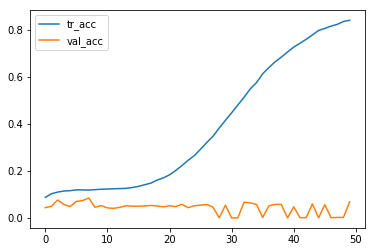

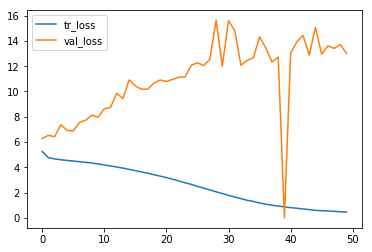

In [73]:
history = pd.DataFrame()
history['tr_acc'] = hist_ta
history['val_acc'] = hist_va
history['tr_loss'] = hist_tl
history['val_loss'] = hist_vl
display(history[['tr_acc','val_acc']].plot())
display(history[['tr_loss','val_loss']].plot())
history.to_csv('../tf_runs/{0}_x_delete.csv'.format(model_name),index=False)

# Evaluate

In [78]:
model.load_weights('../checkpoints/{0}.h5'.format(model_name))

In [74]:

def predict_captions(image):
    start_word = ["startseq"]
    mask = np.zeros((1,max_wlen,1))+0.001
    counter=0
    while True:
        counter-=1
        mask[:,counter,:]=1.0
        print(np.sum(mask))
        par_caps = [w_to_co[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_wlen, padding='pre',value=0)
        preds = model.predict([image, np.array(par_caps),mask])
#         print(preds.shape)
        idx = preds.argmax(-1)
        word_pred = co_to_w[idx[0]]
#         print(par_caps)
        start_word.append(word_pred)
        
        if word_pred == "endseq" or len(start_word) > max_wlen:
            break
            
    return ' '.join(start_word[1:-1])

# print('Predicted:',' '.join(out_text))

In [75]:
def beam_search_predictions(image, beam_index = 3):
    start = [w_to_co["startseq"]]
    
    # start_word[0][0] = index of the starting word
    # start_word[0][1] = probability of the word predicted
    start_word = [[start, 0.0]]
    mask = np.zeros((1,max_wlen,1))+0.001
    counter=0
    while len(start_word[0][0]) < max_wlen:
        temp = []
        counter-=1
        mask[:,counter,:]=1.0
#         print(np.sum(mask))
        for s in start_word:
            
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_wlen, padding='pre', value=0)
            preds = model.predict([image, np.array(par_caps),mask])
            
            # Getting the top <beam_index>(n) predictions
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # creating a new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [co_to_w[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
ref_sents = []
pred_sents = []
for counter in tqdm(range(len(test_images_list))):
    testx,testy = next(test_gen)
    photo = testx['image_input'][0]
#     plt.imshow(photo)
#     plt.show()
    photo = np.expand_dims(photo,0)
    
#     print('Actual:',testy['actual_sentence'][0])
#     print()
    # st = time()
    # pred_greedy = predict_captions(photo)
    # et = time()
    # print('Greedy Predicted:{0},[{1:.2f} s]'.format(pred_greedy,et-st))
#     st = time()
    pred_bm5 = beam_search_predictions(photo,beam_index=5)
#     et = time()
#     print('Beam-5 Predicted:{0},[{1:.2f} s]'.format(pred_bm5,et-st))
    ref_sents.append(testy['actual_sentence'][0])
    pred_sents.append(pred_bm5)
    if counter==10:
        break

In [77]:

# st = time()
# pred_greedy = predict_captions(photo)
# et = time()
# print('Greedy Predicted:{0},[{1:.2f} s]'.format(pred_greedy,et-st))

# st = time()
# pred_bm3 = beam_search_predictions(photo,beam_index=3)
# et = time()
# print('Beam-3 Predicted:{0},[{1:.2f} s]'.format(pred_bm3,et-st))

# st = time()
# pred_bm5 = beam_search_predictions(photo,beam_index=5)
# et = time()
# print('Beam-5 Predicted:{0},[{1:.2f} s]'.format(pred_bm5,et-st))

# st = time()
# pred_bm7 = beam_search_predictions(photo,beam_index=7)
# et = time()
# print('Beam-7 Predicted:{0},[{1:.2f} s]'.format(pred_bm7,et-st))
pd.set_option('display.max_colwidth', -1)
df_pred = pd.DataFrame()
df_pred['Ref'] = ref_sents
df_pred['Pred'] = pred_sents
df_pred

,Ref,Pred
0,heart size within normal limits. no focal airspace disease. no pleural effusion.,frontal frontal the the the the the the the the the the xxxx xxxx xxxx xxxx cardiac mediastinal mediastinal lungs scarring limits . lungs . aortic aortic are are noted of of base focal focal are focal noted consolidation consolidation . upper aortic or effusion . no lungs clear . .
1,the lungs are clear. there is no pleural effusion. the heart and mediastinum are normal. the skeletal structures show arthritic changes.,acute lungs no the the xxxx xxxx xxxx xxxx focal and no pneumothorax . and and pulmonary is xxxx . . lungs . aortic are xxxx xxxx xxxx free there focal the lateral volumes are consolidation . pleural effusion . or effusion . bony abnormality . . through
2,"hyperexpansion of the lungs with hyperlucency and flattening of hemidiaphragms suggestive of chronic emphysematous lung disease. heart size within normal limits. bibasilar, right greater than left atelectasis airspace disease noted. no pneumothorax or large pleural effusion. no acute bony abnormality.",the the the the the the the the the the the the the the the the the chest lungs lungs lung lung left left left left left left left left left left left left left lung are are are left is is degenerative . central ct are
3,"the heart is normal in size. the mediastinum is stable. the lungs are grossly clear. xxxx xxxx opacities in the lung bases. there are xxxx fragments overlying the posterior left chest, right neck base and xxxx fragments in the left costophrenic xxxx. there is no pleural effusion or pneumothorax.",acute lungs no the no xxxx xxxx xxxx focal the and contour and the pneumothorax . silhouette is . lungs . . lungs . aortic are xxxx clear of there focal the lateral volumes volumes are . pleural effusion . or effusion . bony bony . .
4,heart size and mediastinal contours are normal in appearance. no consolidative airspace opacities. no radiographic evidence of pleural effusion or pneumothorax. visualized osseous structures appear intact.,acute soft soft right no no xxxx xxxx lungs the right
5,there is a minimally displaced fracture of the right lateral 7th rib. there is a small right pleural effusion with associated atelectasis of the right lower lobe. there appears to be a healing fracture of the posterolateral right 8th rib. there is questionable cortical defect involving the sternum seen xxxx on lateral view. xxxx would be xxxx to evaluate this finding. as the small right-sided pleural effusion is visible on both pa and lateral views. there is a xxxx left-sided pleural effusion as well. the left lung appears grossly clear. heart size and pulmonary xxxx appear normal. there is a mild scoliosis involving the thoracic spine.,"acute lungs the no no xxxx xxxx xxxx focal the no focal . pneumothorax are , mediastinal is is . . lungs . lungs are are xxxx clear of there focal are lateral are are . pleural effusion or or effusion . bony bony . ."
6,"heart size mildly enlarged, stable mediastinal and hilar contours, mediastinal calcifications suggest a previous granulomatous process. no focal alveolar consolidation, no definite pleural effusion seen. no typical findings of pulmonary edema.",the frontal the the the the the the the the the the the the the chest xxxx cardiac mediastinal lung mediastinal lungs the the lungs . aortic the aortic xxxx xxxx of the focal the focal volumes are consolidation consolidation . pleural . aortic effusion . . with were
7,"there are diffuse increased interstitial markings, suggestive of pulmonary fibrosis in bilateral lung xxxx. the fibrosis appears to slightly increased xxxx compared to previous examination, in xxxx. the trachea is midline. negative for pneumothorax, pleural effusion. the heart size is normal.",frontal frontal right the the the the the the the the xxxx xxxx xxxx cardiac mediastinal heart pulmonary of lungs in . the lungs . aortic the aortic xxxx xxxx xxxx of there focal are lateral are noted consolidation . xxxx aortic 

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
rouge = Rouge()
reference = nlp(str(vy['actual_sentence'][0]))
reference = [[str(x) for x in list(reference)]]


# candidate = nlp(pred_greedy)
# candidate = [str(x) for x in list(candidate)]
# df_result['greedy'] = [sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))]

# candidate = nlp(pred_bm3)
# candidate = [str(x) for x in list(candidate)]
# df_result['bm3'] = [sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))]
row = []
for i in range(len(ref_sents)):
    r = ref_sents[i]
    c = pred_sents[i]
    reference = nlp(str(r))
    reference = [[str(x) for x in list(reference)]]
    candidate = nlp(str(c))
    candidate = [str(x) for x in list(candidate)]
    row.append([sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
                          ,sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
                          ,sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0))
                          ,sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
                          ,rouge.get_scores(hyps=c,refs=r)[0]['rouge-l']['f']])


# candidate = nlp(pred_bm7)
# candidate = [str(x) for x in list(candidate)]
# df_result['bm7'] = [sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))]
df_result = pd.DataFrame(row)
df_result.columns = ['BLEU-1','BLEU-2','BLEU-3','BLEU-4','ROUGE-L']
df_result=df_result.round(3)

In [ ]:
# ref_sents,pred_sents
df_result.mean()

In [ ]:
pd.DataFrame(row)

In [ ]:

reference = str(vy['actual_sentence'][0])
# reference = [[str(x) for x in list(reference)]]
candidate = pre
# candidate = [str(x) for x in list(candidate)]
ro = rouge.get_scores(hyps=candidate,refs=reference)
ro[0]['ROUGE-L']['f']

In [ ]:
pd.DataFrame(ro[0]).T

In [ ]:
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor

In [ ]:
def calc_scores(ref, hypo):
    """
    ref, dictionary of reference sentences (id, sentence)
    hypo, dictionary of hypothesis sentences (id, sentence)
    score, dictionary of scores
    """
    scorers = [
#         (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
#         (Meteor(),"METEOR"),
        (Rouge(), "ROUGE_L"),
        (Cider(), "CIDEr")
    ]
    final_scores = {}
    for scorer, method in scorers:
        score, scores = scorer.compute_score(ref, hypo)
        if type(score) == list:
            for m, s in zip(method, score):
                final_scores[m] = s
        else:
            final_scores[method] = score
    return final_scores 

In [ ]:
calc_scores(ref=ref_sents,hypo=pred_sents)

In [ ]:
from nlgeval import NLGEval
nlgeval = NLGEval()  # loads the models


In [ ]:
references = []
hypothesis = []
import pickle
import numpy as np
with open('../dataset/chestxray_cnn_attention_decoder_ref_sents.p', 'rb') as file:
    # store the data as binary data stream
    references=pickle.load(file)
with open('../dataset/chestxray_cnn_attention_decoder_pred_sents.p', 'rb') as file:
    # store the data as binary data stream
    hypothesis=pickle.load(file)
    
references=np.array(references)
hypothesis=np.array(hypothesis)
references[:2],hypothesis[:2]

In [ ]:
refs=np.expand_dims(ref_sents,1)
# hyps=np.expand_dims(hypothesis,0)
refs=refs.tolist()
# hyps=hyps.tolist()
hypothesis = pred_sents
len(refs),len(hypothesis)

In [ ]:
metrics_dict = nlgeval.compute_metrics(refs, hypothesis)

In [ ]:
r = {idx: strippedlines for (idx, strippedlines) in enumerate(refs)}

In [ ]:
len(r)

In [ ]:
h = {idx: [lines.strip()] for (idx, lines) in enumerate(hypothesis)}

In [ ]:
len(h)

In [ ]:
refs[0],hypothesis[0]

In [ ]:
from nlgeval import compute_individual_metrics


In [ ]:
metrics_dict = compute_individual_metrics(refs[1], hypothesis[1])

In [ ]:
import pandas as pd
df = pd.DataFrame.from_dict(metrics_dict,orient='index').T

In [ ]:
df = pd.DataFrame()
for i in range(300):
    m = nlgeval.compute_individual_metrics(refs[i], hypothesis[i])
    d = pd.DataFrame.from_dict(m,orient='index').T
    df = df.append(d)
    print(np.around(i*100//300,2),end='\r')

In [ ]:
df.shape

In [ ]:
df.mean()

In [ ]:
testx,testy = next(test_gen)
plt.imshow(testx['image_input'][1])

In [ ]:
testx.keys()

In [ ]:
model_img2_text_ca_1 = Model(model.inputs,model.get_layer('img2_text_ca_1').output)
model_text2_img_ca_1 = Model(model.inputs,model.get_layer('text2_img_ca_1').output)
model_text2_img_ca_2 = Model(model.inputs,model.get_layer('text2_img_ca_2').output)
model_text2_img_ca_3 = Model(model.inputs,model.get_layer('text2_img_ca_3').output)
model_text2_img_ca_4 = Model(model.inputs,model.get_layer('text2_img_ca_4').output)

In [ ]:
fi2t,bi2t = model_img2_text_ca_1.predict(testx)
ft2i_1,bt2i_1 = model_text2_img_ca_1.predict(testx)
ft2i_2,bt2i_2 = model_text2_img_ca_2.predict(testx)
ft2i_3,bt2i_3 = model_text2_img_ca_3.predict(testx)
ft2i_4,bt2i_4 = model_text2_img_ca_4.predict(testx)

In [ ]:
bt2i_add = bt2i_1+bt2i_1+bt2i_1+bt2i_1

In [ ]:
bt2i_add.shape

In [ ]:
for j in range(bt2i_add.shape[0]):    
    i=testx['words_input'][j][-1]
    if i!=0:
        print(j,':',co_to_w[i])
        plt.imshow(bt2i_add[j])
        plt.show()

In [ ]:

for i in range(pd.DataFrame(bt2i_add[j]).shape[0]):
    print('Row:{0},Max Col Idx:{1},Max Col Value:{2}'.format(i,np.argmax(bt2i_add[j][i]),np.max(bt2i_add[j][i])))

In [ ]:
plt.imshow(cv2.resize(bt2i_add[j][57].reshape((8,8)),(256,256),cv2.INTER_CUBIC),cmap='jet')

In [ ]:
plt.imshow(testx['image_input'][1])
plt.imshow(cv2.resize(bt2i_add[j][57].reshape((8,8)),(256,256),cv2.INTER_CUBIC),cmap='jet',alpha=0.2)

In [ ]:
testx['words_input'].shape